In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [281]:
image = cv2.imread('1.jpg', cv2.IMREAD_COLOR)

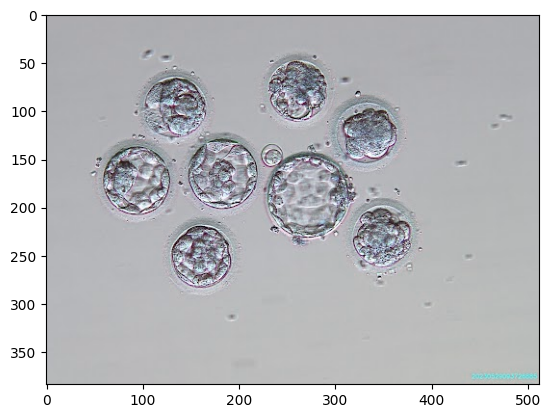

In [282]:
plt.imshow(image)

In [283]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

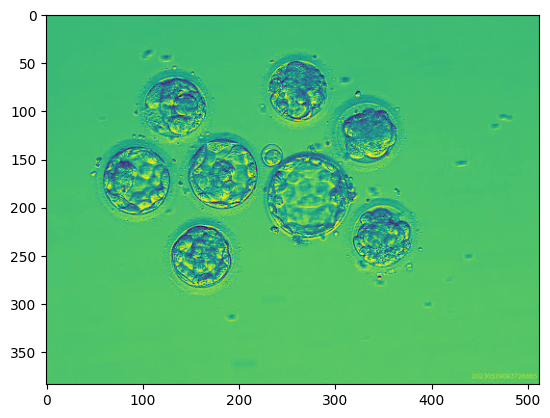

In [284]:
plt.imshow(gray)

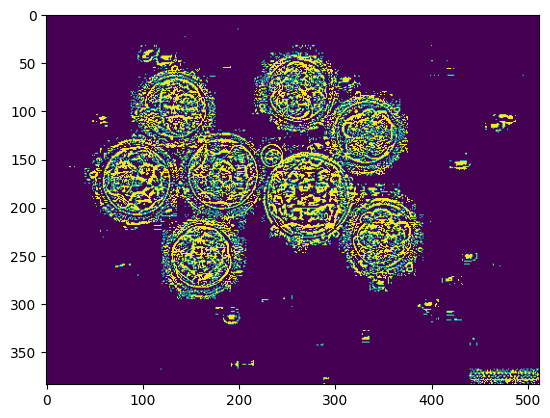

In [285]:
# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
plt.imshow(thresh)

In [218]:
# Erosion to separate embryos that are close
kernel = np.ones((2,2),np.uint8)  # You may need to adjust the kernel size
eroded = cv2.erode(thresh, kernel, iterations = 1)

In [286]:
# Find contours
contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

In [287]:
# # Find contours
# contours, _ = cv2.findContours(
#         eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#     )

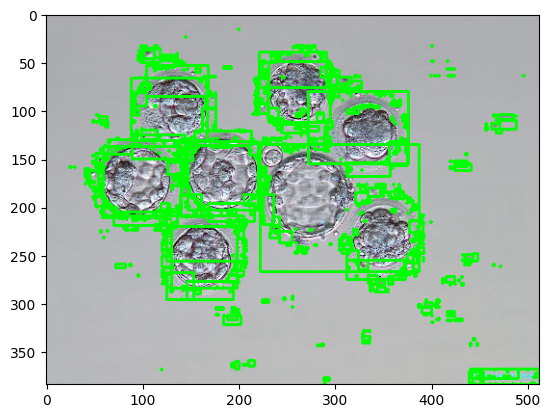

In [288]:
# Draw bounding boxes on the original image
image = cv2.imread('1.jpg', cv2.IMREAD_COLOR)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Check for elongated contours which might indicate multiple embryos
    aspect_ratio = w/h
    if 2.67 < aspect_ratio < 0.5:  # Adjust these values based on your observations
        continue  # Skip this contour if it's likely two embryos
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green color bounding box

# Show the original image with bounding boxes
# cv2.imshow("Embryos with Bounding Boxes", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(image)
plt.show()


In [289]:
len(contours)

889

In [290]:
# Filter out small areas to reduce false positives
MIN_EMBRYO_AREA = 500  # adjust
filtered_contours = [c for c in contours if cv2.contourArea(c) > MIN_EMBRYO_AREA]

In [291]:
len(filtered_contours)

7

1.0625
1.125
1.25
1.028169014084507
1.3866666666666667
1.2153846153846153
1.0158730158730158


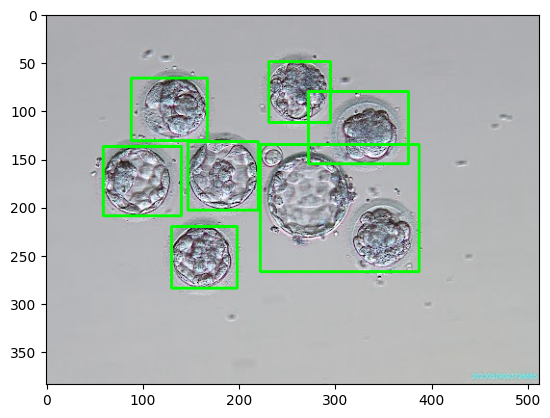

In [292]:
# Draw bounding boxes on the original image
image = cv2.imread('1.jpg', cv2.IMREAD_COLOR)
for i, contour in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(contour)
    # Check for elongated contours which might indicate multiple embryos
    aspect_ratio = w/h
    print(aspect_ratio)
    if 1.5 < aspect_ratio < 1.0:
        continue  # Skip this contour if it's likely two embryos    
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green color bounding box
    # plt.imshow(image)
    # plt.show()

# Show the original image with bounding boxes
# cv2.imshow("Embryos with Bounding Boxes", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.clf()
plt.imshow(image)

In [11]:
cropped_embryos = []
for contour in contours:
    # Get bounding box and extract ROI using Numpy slicing
    x, y, w, h = cv2.boundingRect(contour)
    cropped = image[y : y + h, x : x + w]
    cropped_embryos.append(cropped)

In [24]:
for i, embryo in enumerate(cropped_embryos):
    cv2.imshow(f"Embryo{i+1}", embryo)
cv2.waitKey(0)
cv2.destroyAllWindows()
    
# plt.imshow(cropped_embryos[0])

In [ ]:
image.shape

(384, 512, 3)

# WATERSHED

In [401]:
image = cv2.imread('1.jpg', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Binary threshold
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Apply adaptive thresholding
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# Compute distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
_, dist_output = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

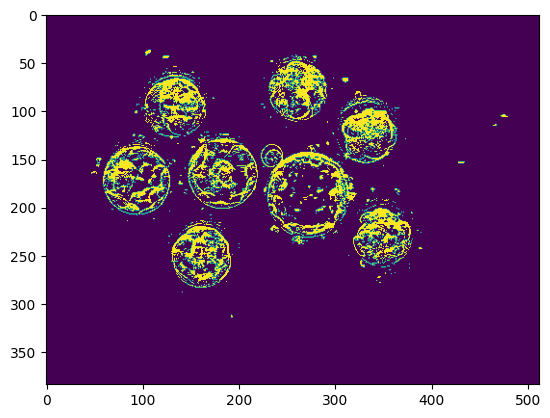

In [402]:
plt.imshow(dist_output)

In [403]:
# Find sure background and sure foreground
sure_bg = cv2.dilate(thresh, None, iterations=3)
sure_fg = np.uint8(dist_output)
    
# Subtract sure foreground from sure background
unknown = cv2.subtract(sure_bg, sure_fg)

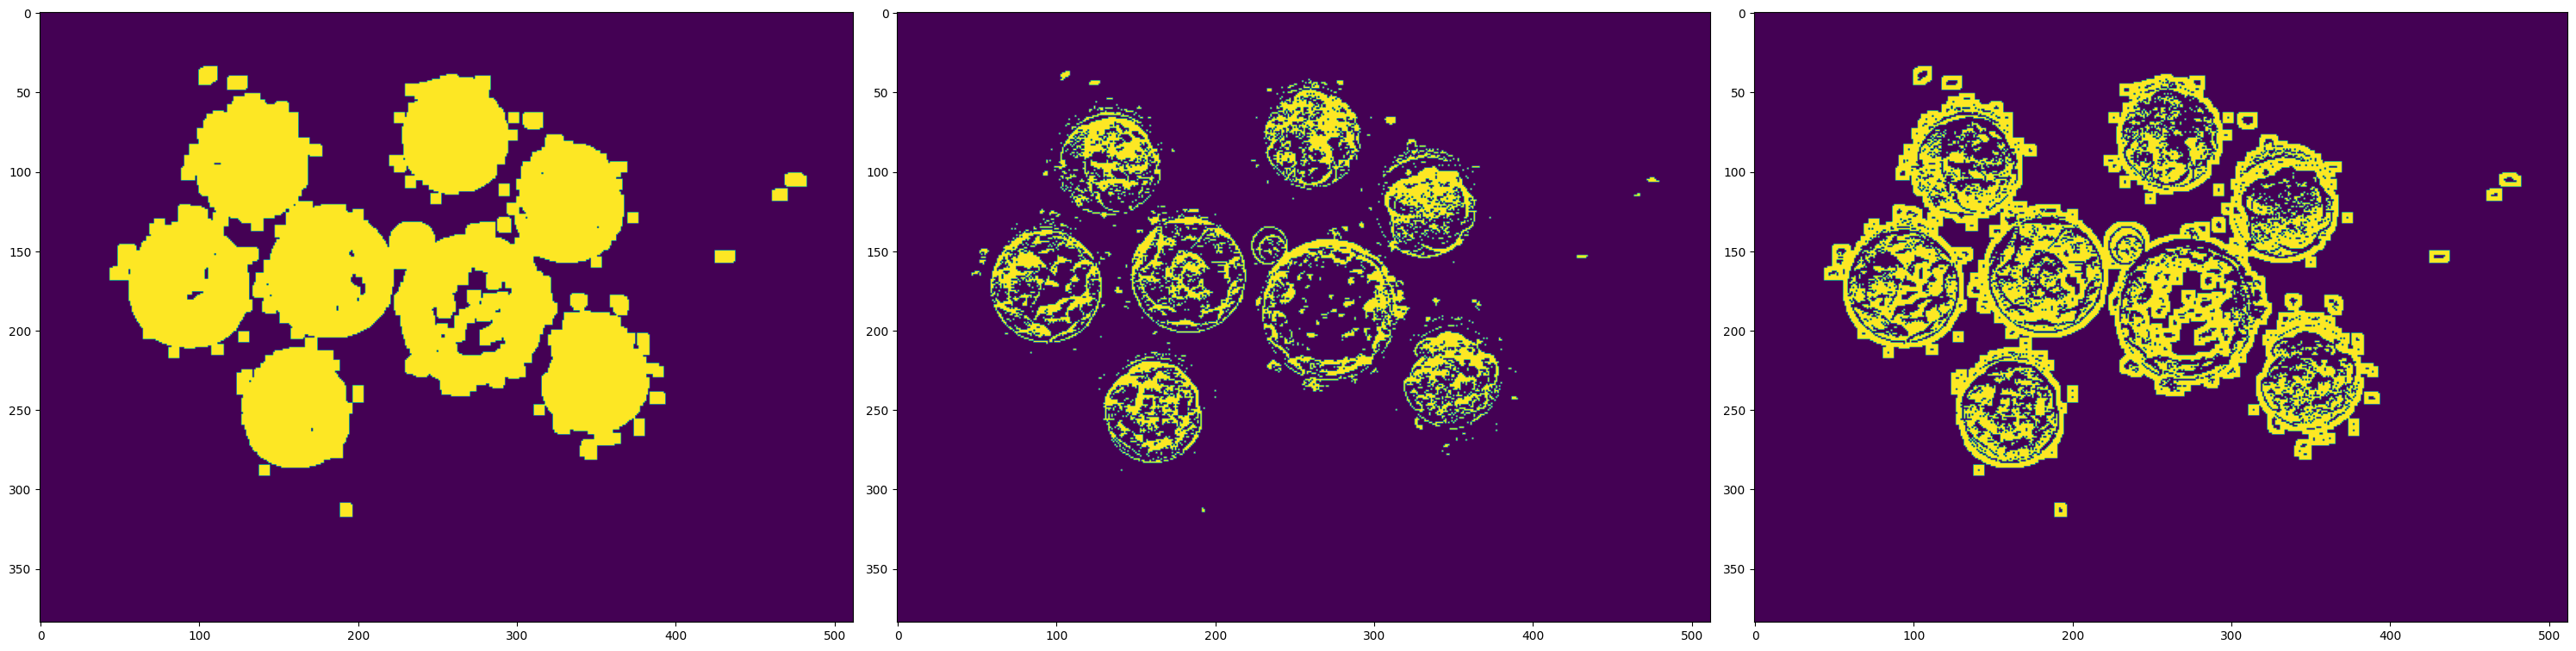

In [404]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) 

axs[0].imshow(sure_bg)
axs[1].imshow(sure_fg)
axs[2].imshow(unknown)
# for ax in axs:
#     ax.axis('off')
plt.tight_layout()
plt.show()

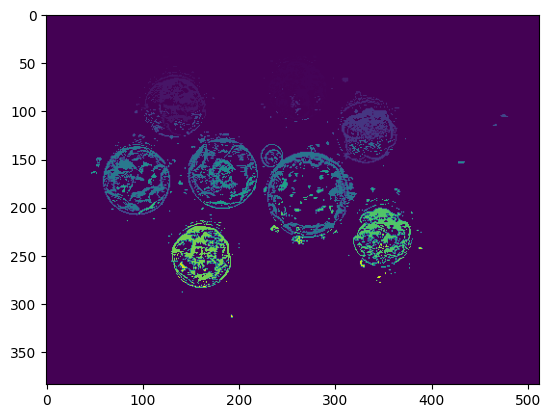

In [405]:
# Label markers
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
plt.imshow(markers)

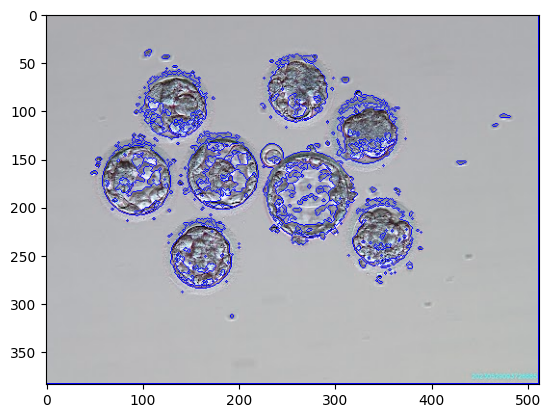

In [406]:
# Apply watershed
cv2.watershed(image, markers)
image[markers == -1] = [0, 0, 255]  # Mark watershed boundary with red color
    
plt.imshow(image)

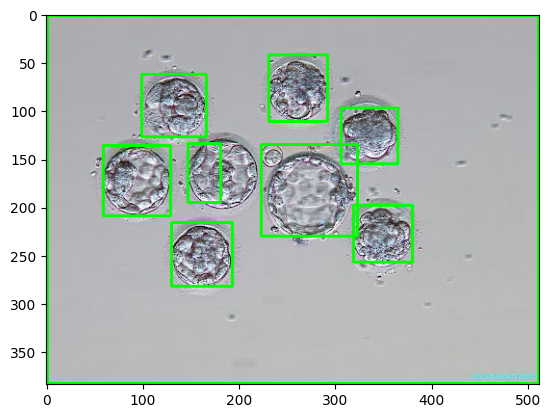

In [407]:
# Extract the embryos using the markers
image = cv2.imread('1.jpg', cv2.IMREAD_COLOR)
for label in np.unique(markers):
    if label == -1:
        continue  # Not interested in the background
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[markers == label] = 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    MIN_EMBRYO_AREA = 700  # adjust
    filtered_contours = [c for c in contours if cv2.contourArea(c) > MIN_EMBRYO_AREA]
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box
plt.imshow(image)